# Project 3: Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt

from collections import deque
import torch
import time

%matplotlib inline

CUDA_LAUNCH_BLOCKING=1

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

# Testing
next_states = np.reshape(env_info.vector_observations, (1, num_agents*state_size))
print(next_states)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -6.65278625 -1.5
  -0.          0.          6.83172083  6.         -0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -6.4669857  -1.5
   0.          0.         -6.83172083  6.          0.          0.        ]]


## 3. Overview of Solution

### 3.1 Algorithm

The actor critic algorithm selected to complete this task was Proximal Policy Optimization (PPO) with a clipped objective. This is an on-policy algorithm. In addition Generalized Advantage Estimation (GAE) has been imlemented. The implementation of the alogrithm has been based a PPO implementation by Phil Tabor (https://github.com/philtabor/Youtube-Code-Repository/tree/master/ReinforcementLearning/PolicyGradient/PPO/torch) but has been adapted for both a continuous environment as well as the use of multiple agents.


### 3.2 Network Design

Separate networks have been produced for both the actor and critic, with no shared elements. This architecture showed similar or better performance than some other alternatives with a shared input layer(s). An overview of the architecture is given below. The actor policy generates actions stochastically from a normal distribution.

Actor

    s -> Linear(s, 128) -> ReLU -> Linear(128, 64) -> ReLU -> Linear(64, a) -> Tanh -> Normal Distribution,
        where s and a is the state and action space sizes respectively.

Critic

    s -> Linear(s, 128) -> ReLU -> Linear(128, 64) -> ReLU -> Linear(64, 1) -> V(s)

The logic for the actor and critic networks is implemented as class `ActorNetwork` and `CriticNetwork` within `ppo_original.py`.

### 3.3 Hyperparameters

Agent hyperparameters are passed to the constructor class `Agent` in `ppo_original.py`. The hyperparameter values have been selected by a limited optimization process of varying the values and determining the best values for stability and performance.

| parameter                | value      | description                                                                   |
|--------------------------|------------|-------------------------------------------------------------------------------|
| optimizer_learning_rate  | 8e-4       | Learning rate for Adam optimizer                                              |
| gamma                    | 0.99       | Discount rate for future rewards                                              |
| gae_lambda               | 0.95       | Smoothing parameter for GAE                                                   |
| n_epochs                 | 10         | Number of optimization steps to perform after trajectory rollback             |
| batch_size               | 256        | Number of N-agent experiences to collect for a single optimization step       |
| policy_clip              | 0.2        | Clipping parameter for the policy loss function                               |
| value_loss_weight        | 0.5        | Weight applied to value loss on total loss function                           |

The training hyperparameters defined below are passed to the training function, `train_agent`, defined within this workbook. 

| parameter                     | value     | description                                           |
|-------------------------------|-----------|-------------------------------------------------------|
| n_episodes                    | 5000      | Maximum number of training episodes                   |
| N                             | 1024      | Trajectory length, Number of timesteps before         |
|                                             performing a policy update                            |

In [5]:
from ppo_original import Agent

#Set agent hyperparameters
alpha = 8e-4 #8e-4
gamma = 0.99 #B-0.99
gae_lambda = 0.95 #B-0.95 #Smoothing parameter
n_epochs=10 #B-10
batch_size=256 #B-256
policy_clip = 0.2 #B-0.2
value_loss_weight = 0.5 
gradient_clip = 13 #B-13

# Initialize agent
agent = Agent(action_size, state_size, gamma, alpha, gae_lambda, policy_clip, batch_size, n_epochs, value_loss_weight, num_agents,
             gradient_clip)


In [6]:
def train_agent_(env, agent, n_episodes=300, max_t=250, 
    display_every=100, solved_score=0.5, N=250):
    
    st_time = time.time()
    
    scores = []
    mean_scores = []
    
    scores_window = deque(maxlen=100)
    max_mean = 0
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    n_steps = 0
    
    for i_episode in range(1, n_episodes + 1):    
        
        
        env_info = env.reset(train_mode=True)[brain_name]
        
        
        score = np.zeros(num_agents)
        episode_length_list = []
        
        states = env_info.vector_observations

        first_solved = True
        
        while True:

            actions, probs, vals = agent.choose_action(states)
            
            env_info = env.step(actions)[brain_name]
            
            next_states = env_info.vector_observations
            
            rewards = env_info.rewards      
            
            dones = env_info.local_done
            
            n_steps += 1
            
            score += rewards
            
            agent.remember(states, actions, probs, vals, rewards, dones)
            
            states = next_states
            
            if n_steps % N ==0:
            
                agent.learn(n_steps)

            if np.any(dones):
                break
                
        max_score = np.max(score) # for each agent
        scores_window.append(max_score)       # save most recent score
        mean_scores.append(np.mean(scores_window))
        scores.append(max_score)              # save most recent score for plotting
        
        print('\rEpisode {}\tMax score: {:.2f}'.format(
            i_episode, max_score), end="")
        
        if i_episode % display_every == 0:
            print('\rEpisode {}\tAverage score: {:.2f}'.format(
                i_episode, np.mean(scores_window)))
            
        if np.mean(scores_window) >= solved_score and np.mean(scores_window) > max_mean:
        # if score is greater than solved criteria, and greater than previous best score report and save
        # aim is to allow training to continue to reach optimal policy possible
        
            if first_solved == True:
            
                print('\nEnvironment solved in {:d} episodes!\tAverage score: {:.2f} - saving model'.format(
                    np.maximum(i_episode, 0), np.mean(scores_window)))
                
                first_solve = False
                
            else:
                
                print('\nHigher average score achieved at {:d} episodes!\tAverage score: {:.2f} - saving model'.format(
                    np.maximum(i_episode, 0), np.mean(scores_window)))
                
            
            torch.save(agent.critic.state_dict(), 'critic_ppo.pth')
            torch.save(agent.actor.state_dict(), 'actor_ppo.pth')
            #agent.save_models
            
            max_mean = np.mean(scores_window)

    
        
    print('\nRun Time: {:.2f}s'.format(time.time() - st_time))
    
    return scores, mean_scores

In [7]:
scores, mean_scores = train_agent_(env, agent, n_episodes=5000, solved_score = 0.5, N=1024)

Episode 100	Average score: 0.02
Episode 200	Average score: 0.02
Episode 300	Average score: 0.02
Episode 400	Average score: 0.02
Episode 500	Average score: 0.03
Episode 600	Average score: 0.04
Episode 700	Average score: 0.05
Episode 800	Average score: 0.07
Episode 900	Average score: 0.08
Episode 1000	Average score: 0.10
Episode 1100	Average score: 0.11
Episode 1200	Average score: 0.14
Episode 1300	Average score: 0.18
Episode 1400	Average score: 0.24
Episode 1500	Average score: 0.39
Episode 1524	Max score: 2.60
Environment solved in 1524 episodes!	Average score: 0.50 - saving model
Episode 1525	Max score: 2.60
Environment solved in 1525 episodes!	Average score: 0.52 - saving model
Episode 1526	Max score: 0.90
Environment solved in 1526 episodes!	Average score: 0.53 - saving model
Episode 1528	Max score: 2.60
Environment solved in 1528 episodes!	Average score: 0.55 - saving model
Episode 1530	Max score: 1.70
Environment solved in 1530 episodes!	Average score: 0.56 - saving model
Episode 1

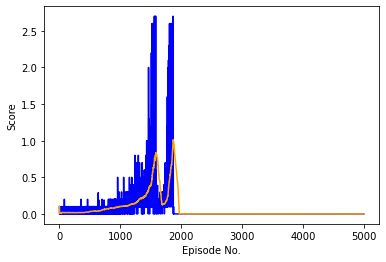

In [8]:
# plot scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Max score', color='blue')
plt.plot(np.arange(len(scores)), mean_scores, label='Avg score', color='orange')
plt.ylabel('Score')
plt.xlabel('Episode No.')
plt.show()

In [9]:
# load the saved checkpoint files
agent.critic.load_state_dict(torch.load('critic_ppo.pth'))
agent.actor.load_state_dict(torch.load('actor_ppo.pth'))
agent.critic.eval()
agent.actor.eval()


for i in range(1, 10 + 1):                                      # play game for 5 episodes
    t = 0
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions, _, _ = agent.choose_action(states)
     
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        t+=1
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))
    print(t)



Score (max over agents) from episode 1: 2.3000000342726707
904
Score (max over agents) from episode 2: 0.800000011920929
334
Score (max over agents) from episode 3: 2.600000038743019
1001
Score (max over agents) from episode 4: 0.800000011920929
286
Score (max over agents) from episode 5: 2.0000000298023224
786
Score (max over agents) from episode 6: 2.500000037252903
962
Score (max over agents) from episode 7: 0.4000000059604645
142
Score (max over agents) from episode 8: 2.600000038743019
1001
Score (max over agents) from episode 9: 2.7000000402331352
1001
Score (max over agents) from episode 10: 0.0
5


In [10]:
env.close()

## 4. Results & Conclusions & Future Work

The selected algorithm was successful in solving the environment within the requirements with a fast timeframe (<10 mins on high end consumer PC with a RTX2080 Ti). The PPO algorithm demonstrated a reasonable level of robustness but was found to be very sensitive to changes in hyperparameters, with the documented hyperparameters giving the best performance. It was noted that in some cases the environment wasn't solved with the stated architecture/hyperparameters but subsequent runs would solve.

Some ideas for future work include:
- Further improving the algorithm to improve robustness to avoid failed runs in some cases (i.e. where model does not learn).
- Performance comparison to other algorithms, for example the DDPG benchmark.
- Review of further improvements to PPO algorithm to improve performance - i.e. input and advantage normalization, modifications to the clipping function suggested in some continuous control papers.